<a href="https://colab.research.google.com/github/yashmishra328/Multi-Stage-Alzheimer-s-Disease-Classification-from-MRI-using-a-ResNet-50-Deep-Learning-Model/blob/main/Alzheimer's_Stages_Classification_ML_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
print("Google Drive mounted.")

Mounted at /content/drive
Google Drive mounted.


--- STAGE 1: Initial Setup, Configuration, and Data Loading (Google Colab with Zip Extraction) ---
  Importing All Necessary Libraries...
  All libraries imported successfully.

  Setting Global Configuration Variables...
    Google Drive Zip Path: /content/drive/MyDrive/Colab Notebooks/Alzheimer's Disease Dataset/Combined Dataset/archive.zip
    Local Colab Extraction Path: /content/Alzheimer_Dataset_Extracted
    Target Dataset Base Path (after extraction): /content/Alzheimer_Dataset_Extracted/Combined Dataset/train
    Target Image Size: 224x224
    Batch Size: 16
    Random State for Splits: 42
    Number of DataLoader Workers: 2
    Target Training Epochs: 10
    Initial Learning Rate: 0.001 (for Adam)
    LR Scheduler Step Size: 7
    LR Scheduler Gamma: 0.1
  Configuration variables set.

  Mounting Google Drive (if not already mounted)...
    Google Drive appears to be already mounted or accessible.
    Drive mount check/attempt took 0.00s.

  Checking and Extracting Dataset fr

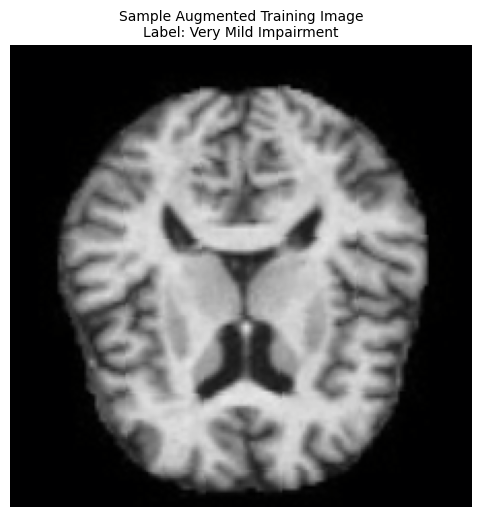


--- STAGE 1 & 2 Complete ---
All setup, data extraction, DataFrame creation, mappings, definitions, data splitting, and DataLoader creation are complete.
Figure 5 (Dataset Distribution) and a sample augmented image have been generated and saved to /content/.
Ready for Stage 3: Model Definition & Training.


In [ ]:
# -*- coding: utf-8 -*-
"""
Combined Stages 1 & 2 (NEW FRESH START v3 - Colab with Zip):
Core Setup, Paths, Zip Extraction, All Imports, Data Loading,
Mappings, Preprocessing Definitions, Data Splitting, DataLoaders & Figure 5.

This script performs all initial setup and data preparation.
"""

# === STAGE 1: SETUP, CONFIGURATION, DATA LOADING, PREPROCESSING DEFINITIONS ===
print("--- STAGE 1: Initial Setup, Configuration, and Data Loading (Google Colab with Zip Extraction) ---")
print("  Importing All Necessary Libraries...")
import numpy as np
import pandas as pd
import os
import warnings
from copy import deepcopy
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import time # To time operations
import itertools # For color cycling in plots
import sys # For printing df.info() to console
import zipfile # For extracting zip files

# Google Colab specific for Drive
from google.colab import drive

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve, average_precision_score,
    balanced_accuracy_score, matthews_corrcoef, ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim # Import optimizers
from torch.optim import lr_scheduler # Import schedulers
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50 _Weights
from torchvision import transforms
print("  All libraries imported successfully.")

# === Configuration Variables (Global for the entire notebook) ===
print("\n  Setting Global Configuration Variables...")

# --- Paths for Drive and Extraction (Using your provided logic) ---
# !!! IMPORTANT: VERIFY THIS ZIP PATH IN YOUR GOOGLE DRIVE !!!
DRIVE_ZIP_PATH = "/content/drive/MyDrive/Colab Notebooks/Alzheimer's Disease Dataset/Combined Dataset/archive.zip"
LOCAL_EXTRACTION_PATH = '/content/Alzheimer_Dataset_Extracted'
# This should be the path to the 'train' folder INSIDE the extracted 'Combined Dataset' folder
DATASET_BASE_PATH = os.path.join(LOCAL_EXTRACTION_PATH, 'Combined Dataset', 'train')

# --- Image, Batch, and Split Parameters ---
IMG_SIZE = 224
BATCH_SIZE = 16
RANDOM_STATE = 42
NUM_WORKERS = 2

# --- Training Hyperparameters ---
EPOCHS = 10
LEARNING_RATE = 0.001 # Using Adam, so a smaller LR is typical
OPTIMIZER_TYPE = 'Adam'
STEP_SIZE = 7
GAMMA = 0.1

print(f"    Google Drive Zip Path: {DRIVE_ZIP_PATH}")
print(f"    Local Colab Extraction Path: {LOCAL_EXTRACTION_PATH}")
print(f"    Target Dataset Base Path (after extraction): {DATASET_BASE_PATH}")
print(f"    Target Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"    Batch Size: {BATCH_SIZE}")
print(f"    Random State for Splits: {RANDOM_STATE}")
print(f"    Number of DataLoader Workers: {NUM_WORKERS}")
print(f"    Target Training Epochs: {EPOCHS}")
print(f"    Initial Learning Rate: {LEARNING_RATE} (for {OPTIMIZER_TYPE})")
print(f"    LR Scheduler Step Size: {STEP_SIZE}")
print(f"    LR Scheduler Gamma: {GAMMA}")

# Ignore warnings for cleaner output
warnings.filterwarnings("ignore")
print("  Configuration variables set.")

# === Mount Google Drive (if not already mounted by a separate cell) ===
print("\n  Mounting Google Drive (if not already mounted)...")
mount_start_time = time.time()
if not os.path.isdir("/content/drive/MyDrive"):
    print("    MyDrive not found, attempting to mount...")
    try:
        drive.mount('/content/drive', force_remount=True)
        print("    Drive mounted successfully via script.")
    except Exception as e:
        print(f"    Error mounting Drive: {e}")
        print("    Please ensure you have run 'from google.colab import drive; drive.mount(\"/content/drive\")' in a separate cell and authorized access if this fails.")
        raise SystemExit("Stopping execution: Drive could not be mounted or accessed.")
else:
    print("    Google Drive appears to be already mounted or accessible.")
mount_end_time = time.time()
print(f"    Drive mount check/attempt took {mount_end_time - mount_start_time:.2f}s.")

# === Extract Data from Zip File ===
print("\n  Checking and Extracting Dataset from Google Drive...")
extract_start_time = time.time()
if not os.path.isdir(DATASET_BASE_PATH): # Only extract if the target 'train' directory doesn't exist
    print(f"    Dataset target path '{DATASET_BASE_PATH}' not found. Attempting to extract '{os.path.basename(DRIVE_ZIP_PATH)}'...")
    os.makedirs(LOCAL_EXTRACTION_PATH, exist_ok=True)
    try:
        if not os.path.exists(DRIVE_ZIP_PATH):
            print(f"    CRITICAL ERROR: Zip file not found at the specified Google Drive path: {DRIVE_ZIP_PATH}")
            raise FileNotFoundError(f"Zip file not found: {DRIVE_ZIP_PATH}")

        print(f"    Starting extraction of '{DRIVE_ZIP_PATH}' to '{LOCAL_EXTRACTION_PATH}'... This may take a few minutes.")
        with zipfile.ZipFile(DRIVE_ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(LOCAL_EXTRACTION_PATH)
        print(f"    Extraction Complete! Files extracted to: '{LOCAL_EXTRACTION_PATH}'")

        if not os.path.isdir(DATASET_BASE_PATH):
            print(f"    CRITICAL ERROR: Expected dataset folder '{DATASET_BASE_PATH}' not found after extraction.")
            print(f"    Please check the contents of the zip file. Expected structure: .../{os.path.basename(LOCAL_EXTRACTION_PATH)}/Combined Dataset/train/")
            print(f"    Current contents of '{LOCAL_EXTRACTION_PATH}': {os.listdir(LOCAL_EXTRACTION_PATH)}")
            if os.path.isdir(os.path.join(LOCAL_EXTRACTION_PATH, 'Combined Dataset')):
                 print(f"    Contents of '{os.path.join(LOCAL_EXTRACTION_PATH, 'Combined Dataset')}': {os.listdir(os.path.join(LOCAL_EXTRACTION_PATH, 'Combined Dataset'))}")
            raise FileNotFoundError(f"Expected dataset folder not found after extraction: {DATASET_BASE_PATH}")
        print(f"    Dataset base path verified after extraction: '{DATASET_BASE_PATH}'")
    except Exception as e:
        print(f"    An error occurred during extraction: {e}")
        raise SystemExit("Stopping execution: Cannot extract data.")
else:
    print(f"    Dataset already appears to be extracted and available at: '{DATASET_BASE_PATH}'")
extract_end_time = time.time()
print(f"    Dataset check/extraction took {extract_end_time - extract_start_time:.2f}s.")

if not os.path.isdir(DATASET_BASE_PATH):
    print("\n  CRITICAL ERROR: Dataset directory not found even after potential extraction attempt.")
    print(f"  Please verify the path: {DATASET_BASE_PATH}")
    raise SystemExit("Stopping execution: Dataset not available at the expected path.")
else:
    print(f"\n  Dataset is confirmed to be ready at: {DATASET_BASE_PATH}")

# === Helper Function: create_df ===
print("\n  Defining create_df Function...")
def create_df(path_to_scan_param): # Renamed parameter
    """Scans a directory structured by class names and creates a DataFrame."""
    func_start_time = time.time()
    print(f"    Scanning data directory: {path_to_scan_param}...")
    dd_func = {"image_path": [], "label": []} # Use local dict
    skipped_files_func = 0
    processed_files_func = 0

    class_dirs_func = sorted([d for d in os.listdir(path_to_scan_param) if os.path.isdir(os.path.join(path_to_scan_param, d))])
    if not class_dirs_func:
        raise ValueError(f"    No class subdirectories found in {path_to_scan_param}.")
    print(f"    Found {len(class_dirs_func)} class directories for DataFrame: {class_dirs_func}")

    for class_name_item_func in class_dirs_func:
        img_dir_func = os.path.join(path_to_scan_param, class_name_item_func)
        count_in_class_func = 0
        for file_name_func in os.listdir(img_dir_func):
            file_path_func = os.path.join(img_dir_func, file_name_func)
            if os.path.isfile(file_path_func) and file_path_func.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tif', '.tiff')):
                dd_func["image_path"].append(file_path_func)
                dd_func["label"].append(class_name_item_func)
                processed_files_func += 1
                count_in_class_func += 1
            else:
                 skipped_files_func += 1
    df_created_func = pd.DataFrame(dd_func)
    func_end_time = time.time()
    print(f"    Finished scanning for DataFrame. Found {processed_files_func} images, skipped {skipped_files_func} items.")
    print(f"    DataFrame creation from path took {func_end_time - func_start_time:.2f} seconds.")
    return df_created_func
print("  create_df function defined.")

# === Load Initial Data into DataFrame ===
print("\n  Loading Initial Dataset into DataFrame from Extracted Colab Path...")
initial_df_load_start_time = time.time()
# Use the DATASET_BASE_PATH which points to the local Colab 'train' directory
initial_df = create_df(DATASET_BASE_PATH) # Call the function
initial_df_load_end_time = time.time()

if initial_df.empty:
    raise ValueError(f"  CRITICAL: No images loaded into DataFrame from the extracted path. Check '{DATASET_BASE_PATH}' and extraction logs.")
else:
    print(f"  Successfully loaded initial data into DataFrame. Shape: {initial_df.shape}")
    print(f"  Total images in DataFrame: {len(initial_df)}")
    print(f"  DataFrame loading took {initial_df_load_end_time - initial_df_load_start_time:.2f} seconds.")

# === Create Label Mappings ===
print("\n  Creating Label Mappings...")
unique_labels_map = sorted(initial_df["label"].unique()) # Renamed variable
NUM_CLASSES = len(unique_labels_map)
if NUM_CLASSES == 0:
     raise ValueError("  CRITICAL: No unique class labels found in DataFrame 'label' column.")

index_to_label = {i: str(lbl_map) for i, lbl_map in enumerate(unique_labels_map)} # Renamed var
label_to_index = {lbl_map: i for i, lbl_map in index_to_label.items()}
class_names = [index_to_label[i] for i in sorted(index_to_label.keys())]

print(f"    Number of unique classes: {NUM_CLASSES}")
print(f"    Class Names: {class_names}")
print("    Index to Label Mapping (index: 'label'):")
for idx_map, lbl_str_map in index_to_label.items(): print(f"      {idx_map}: '{lbl_str_map}'") # Renamed vars

# === Encode Labels in DataFrame ===
print("\n  Encoding Labels in DataFrame...")
initial_df["label_encoded"] = initial_df["label"].map(label_to_index)
print("    Added 'label_encoded' column.")
if initial_df["label_encoded"].isnull().any():
    print("    WARNING: Some labels were not encoded correctly (NaNs found).")
else:
    print("    Label encoding verified successfully.")

# === Display Initial Data Info ===
print("\n  Initial Dataset Summary (from DataFrame):")
print("    DataFrame Info:")
initial_df.info(buf=sys.stdout)
print("\n    DataFrame Head (first 5 rows):")
print(initial_df.head().to_markdown(index=False, numalign="left", stralign="left"))
print("\n    Value Counts per Class (Full Dataset - based on original string labels):")
print(initial_df['label'].value_counts().sort_index().to_markdown(numalign="left", stralign="left"))

# === Define Image Transformations ===
print("\n  Defining Image Transformations...")
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
print("    Training Transformations (with Augmentation) defined.")

val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
print("    Validation/Test Transformations (Preprocessing Only) defined.")

# === Define Custom Dataset Class ===
print("\n  Defining AlzheimerDataset Class...")
class AlzheimerDataset(Dataset): # Class name should be globally unique
    def __init__(self, data_array_param, transform_param=None): # Unique param names
        super(AlzheimerDataset, self).__init__()
        self.data_array = data_array_param # Use passed param
        self.transform = transform_param   # Use passed param
    def __len__(self):
        return len(self.data_array)
    def __getitem__(self, idx):
        img_path_item, label_encoded_item = self.data_array[idx, 0], int(self.data_array[idx, 1])
        try:
            img_pil_item = Image.open(img_path_item).convert("RGB")
            img_np_item = np.array(img_pil_item)
            if self.transform:
                img_tensor_item = self.transform(img_np_item)
            else:
                img_tensor_item = transforms.ToTensor()(img_pil_item)
            label_tensor_item = torch.tensor(label_encoded_item, dtype=torch.long)
            return img_tensor_item, label_tensor_item
        except FileNotFoundError: return None, None
        except Exception as e: return None, None
print("  AlzheimerDataset class defined successfully.")

# === Define Collate Function ===
print("\n  Defining Collate Function...")
def collate_fn(batch_param): # Unique param name
    original_batch_size_cfn = len(batch_param)
    batch_filtered = list(filter(lambda x_cfn: x_cfn is not None and x_cfn[0] is not None and x_cfn[1] is not None, batch_param))
    if not batch_filtered: return torch.tensor([]), torch.tensor([])
    return torch.utils.data.dataloader.default_collate(batch_filtered)
print("  collate_fn defined.")

print("\n--- STAGE 1 (Data Setup) Complete ---")
print("All initial setup, data extraction, DataFrame creation, mappings, and definitions are complete.")
print("Key variables for Stage 2 are: initial_df, RANDOM_STATE, index_to_label, class_names, train_transform, val_test_transform, AlzheimerDataset, BATCH_SIZE, NUM_WORKERS, collate_fn, NUM_CLASSES, EPOCHS, LEARNING_RATE, OPTIMIZER_TYPE, STEP_SIZE, GAMMA")


# === STAGE 2: DATA SPLITTING, DATALOADER CREATION & FIGURE 5 ===
print("\n\n--- STAGE 2: Data Splitting, DataLoaders & Figure 5 ---")

# --- Step 2.1: Split Data ---
print(f"  Step 2.1: Splitting Data (using random_state={RANDOM_STATE})...")
split_start_time = time.time()
data_to_split_s2 = initial_df[['image_path', 'label_encoded']].values # Use initial_df from Stage 1

train_data_np, temp_data_np = train_test_split(
    data_to_split_s2, test_size=0.20, random_state=RANDOM_STATE, stratify=data_to_split_s2[:, 1]
)
val_data_np, test_data_np = train_test_split(
    temp_data_np, test_size=0.50, random_state=RANDOM_STATE, stratify=temp_data_np[:, 1]
)
split_end_time = time.time()
print(f"    Split complete: Train={len(train_data_np)}, Val={len(val_data_np)}, Test={len(test_data_np)}")
print(f"    Data splitting took {split_end_time - split_start_time:.2f} seconds.")
print("    Variables created: train_data_np, val_data_np, test_data_np")

# --- Step 2.2: Generate Figure 5 (Dataset Distribution Plot) ---
print("\n  Step 2.2: Generating Figure 5 (Dataset Distribution Plot)...")
fig5_start_time = time.time()
try:
    train_labels_series_s2 = pd.Series(train_data_np[:, 1]).map(index_to_label)
    val_labels_series_s2 = pd.Series(val_data_np[:, 1]).map(index_to_label)
    test_labels_series_s2 = pd.Series(test_data_np[:, 1]).map(index_to_label)

    train_counts_s2 = train_labels_series_s2.value_counts().sort_index()
    val_counts_s2 = val_labels_series_s2.value_counts().sort_index()
    test_counts_s2 = test_labels_series_s2.value_counts().sort_index()

    plot_df_fig5_s2 = pd.DataFrame({
        'Training Set': train_counts_s2, 'Validation Set': val_counts_s2, 'Test Set': test_counts_s2
    }).fillna(0).astype(int).reindex(class_names).fillna(0).astype(int)

    print("    Class counts per split (for Figure 5):")
    print(plot_df_fig5_s2.to_markdown(numalign="center", stralign="center"))

    fig_fig5_s2, ax_fig5_s2 = plt.subplots(figsize=(12, 8))
    plot_df_fig5_s2.plot(kind='bar', stacked=True, ax=ax_fig5_s2, colormap='viridis', width=0.8)
    ax_fig5_s2.set_title('Figure 5: Distribution of Classes in Dataset Splits', fontsize=16, pad=20)
    ax_fig5_s2.set_xlabel('Alzheimer\'s Stage Class', fontsize=13, labelpad=15)
    ax_fig5_s2.set_ylabel('Number of Images', fontsize=13, labelpad=15)
    ax_fig5_s2.tick_params(axis='x', rotation=25, ha='right', labelsize=11)
    ax_fig5_s2.tick_params(axis='y', labelsize=11)
    ax_fig5_s2.legend(title='Dataset Split', fontsize=11, title_fontsize=12)
    ax_fig5_s2.grid(axis='y', linestyle='--', alpha=0.7)
    for i_bar_s2, class_name_item_s2 in enumerate(plot_df_fig5_s2.index):
        cumulative_height_s2 = 0
        for split_type_s2 in plot_df_fig5_s2.columns:
            value_s2 = plot_df_fig5_s2.loc[class_name_item_s2, split_type_s2]
            if value_s2 > 0:
                 ax_fig5_s2.text(i_bar_s2, cumulative_height_s2 + value_s2 / 2, str(value_s2),
                              ha='center', va='center', fontsize=9, color='white', weight='bold')
            cumulative_height_s2 += value_s2
        ax_fig5_s2.text(i_bar_s2, cumulative_height_s2 + 5, str(plot_df_fig5_s2.loc[class_name_item_s2].sum()),
                     ha='center', va='bottom', fontsize=9, weight='bold')
    plt.tight_layout()
    figure_5_save_path = "/content/figure_5_dataset_distribution.png"
    plt.savefig(figure_5_save_path, dpi=150)
    print(f"    Saved Figure 5 to: {figure_5_save_path}")
    plt.show()
except Exception as e: print(f"    An error occurred generating Figure 5: {e}")
finally:
    if 'fig_fig5_s2' in locals(): plt.close(fig_fig5_s2)
fig5_end_time = time.time()
print(f"    Figure 5 generation took {fig5_end_time - fig5_start_time:.2f} seconds.")

# --- Step 2.3: Create Dataset Instances ---
print("\n  Step 2.3: Creating PyTorch Dataset Instances...")
train_ds = AlzheimerDataset(train_data_np, transform_param=train_transform) # Use train_transform
val_ds = AlzheimerDataset(val_data_np, transform_param=val_test_transform)   # Use val_test_transform
test_ds = AlzheimerDataset(test_data_np, transform_param=val_test_transform)  # Use val_test_transform
print(f"    Train Dataset created (Size: {len(train_ds)}), Val Dataset (Size: {len(val_ds)}), Test Dataset (Size: {len(test_ds)})")
print("    Variables created: train_ds, val_ds, test_ds")

# --- Step 2.4: Create DataLoader Instances ---
print("\n  Step 2.4: Creating PyTorch DataLoader Instances...")
pin_memory_flag_s2 = torch.cuda.is_available()
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=pin_memory_flag_s2, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=pin_memory_flag_s2)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=pin_memory_flag_s2)
print(f"    Train DataLoader (~{len(train_dl)} batches), Val DataLoader ({len(val_dl)} batches), Test DataLoader ({len(test_dl)} batches) created.")
print("    Variables created: train_dl, val_dl, test_dl")

# --- Step 2.5: Display Sample Batch Info & Augmented Image ---
print("\n  Step 2.5: Displaying Sample Batch Info & Augmented Image (from Train Loader)...")
try:
    sample_images_s2, sample_labels_s2 = next(iter(train_dl))
    if sample_images_s2.numel() > 0:
        print(f"      Sample batch retrieved: Images shape: {sample_images_s2.shape}, Labels shape: {sample_labels_s2.shape}")
        plt.figure(figsize=(6,6))
        plt.title(f"Sample Augmented Training Image\nLabel: {index_to_label.get(sample_labels_s2[0].item(), 'Unknown')}", fontsize=10)
        img_to_show_s2 = sample_images_s2[0].cpu().permute(1, 2, 0).numpy()
        mean_disp_s2, std_disp_s2 = np.array([0.485,0.456,0.406]), np.array([0.229,0.224,0.225])
        img_to_show_s2 = std_disp_s2 * img_to_show_s2 + mean_disp_s2
        img_to_show_s2 = np.clip(img_to_show_s2, 0, 1)
        plt.imshow(img_to_show_s2); plt.axis('off')
        sample_aug_img_path_s2 = "/content/figure_sample_augmented_image.png"
        plt.savefig(sample_aug_img_path_s2, dpi=100)
        print(f"      Saved one sample augmented image to: {sample_aug_img_path_s2}"); plt.show(); plt.close()
    else: print("    Sample batch is empty.")
except StopIteration: print("    Could not retrieve sample batch from Train DataLoader (empty or failed).")
except Exception as e: print(f"    Error displaying sample batch: {e}")

print("\n--- STAGE 1 & 2 Complete ---")
print("All setup, data extraction, DataFrame creation, mappings, definitions, data splitting, and DataLoader creation are complete.")
print("Figure 5 (Dataset Distribution) and a sample augmented image have been generated and saved to /content/.")
print("Ready for Stage 3: Model Definition & Training.")

--- STAGE 3: Model Definition, Training Setup & Training ---
  Importing/Verifying Libraries for Stage 3 (most should be loaded)...
  Libraries verified.

  Checking for Variables from Previous Stages...
  All required variables from previous stages found successfully.

  Step 3.1: Defining Model Architecture (ResNet50)...
    Loading ResNet50 pre-trained weights (IMAGENET1K_V2)...


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 59.2MB/s]


    ResNet50 base model loaded with pre-trained weights.
    Original ResNet50 final layer input features: 2048
    Replaced final fc layer. New output features (classes): 4
    Determined device: cuda. Moving model to device...
    Model definition complete and moved to device.

    Model Summary (ResNet50 with modified classifier):
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9   

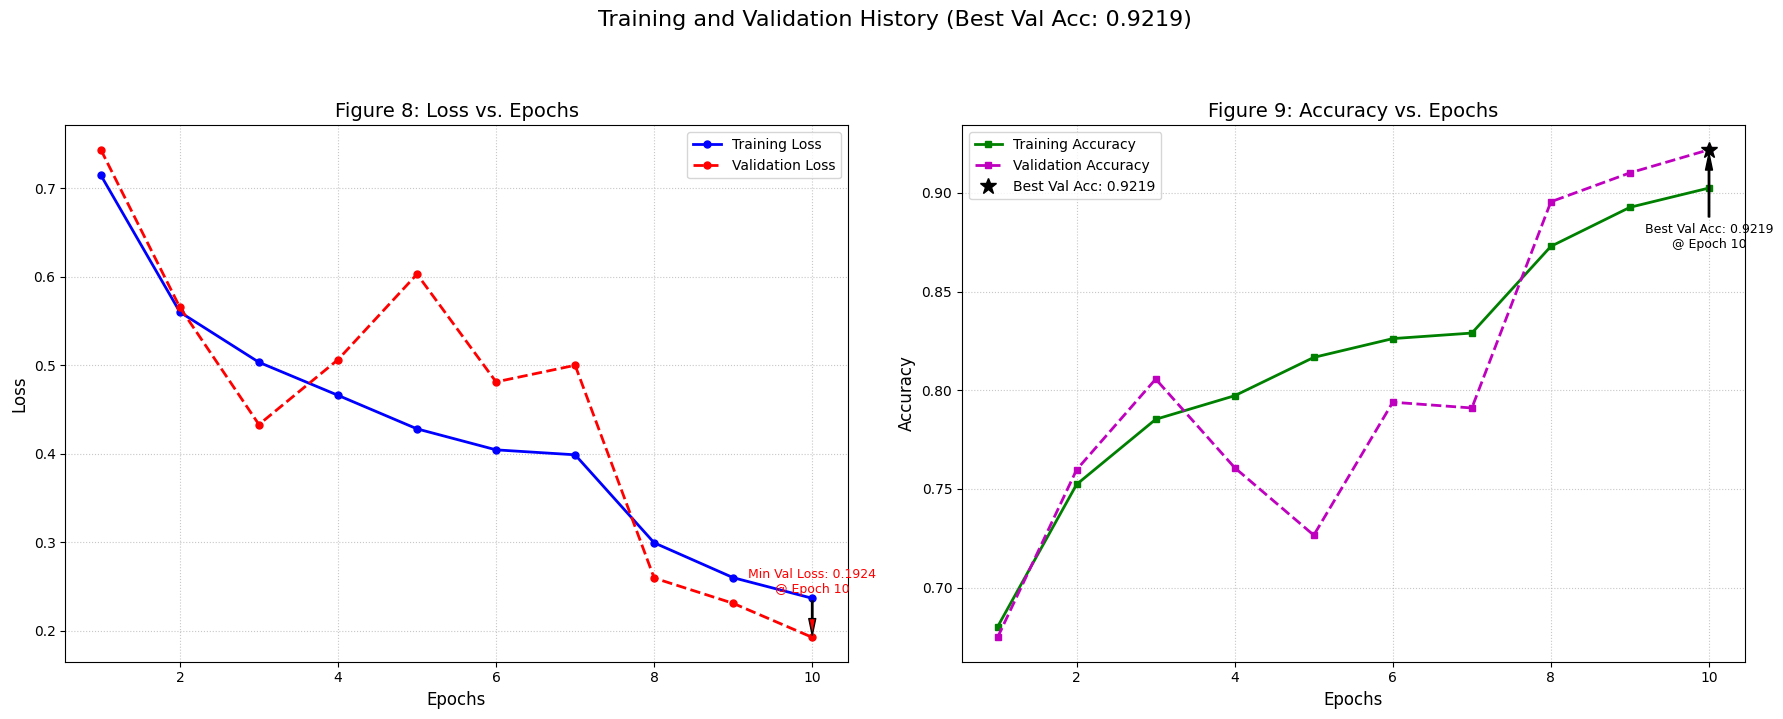

    Training history plot generation took 1.43 seconds.

  Step 3.7: Generating Confusion Matrix on Training Data Subset (Optional)...
    Calculating predictions on a subset of training data for Confusion Matrix...
    Evaluating on up to 1024 training samples for CM...
    Predictions calculated for 1024 training samples.
    Generating training data confusion matrix plot...
    Saved training confusion matrix plot to: /content/figure_extra_train_confusion_matrix.png


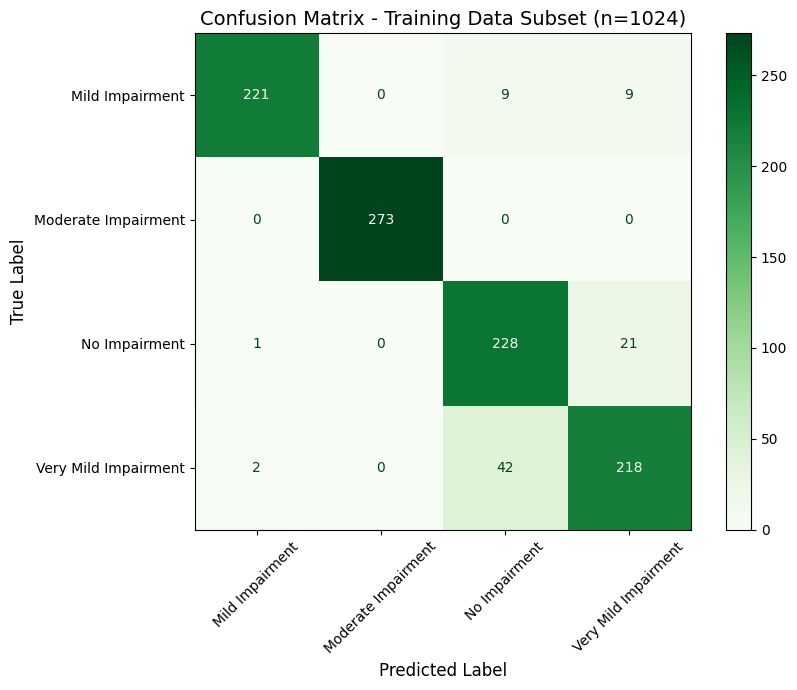

    Training CM generation took 6.14 seconds.

--- STAGE 3 Complete ---
Model has been trained.
Best model weights (Val Acc: 0.9219) are loaded into the 'model' variable and saved to disk at: /content/alzheimer_resnet50_best_trained_acc_0.9219.pth
Training history is stored in the 'history' variable.
Figures 8, 9 and an optional training CM have been generated and saved to /content/.
Variables are ready for Stage 4: Evaluation on Test Set.


In [ ]:
# -*- coding: utf-8 -*-
"""
Stage 3: Model Definition, Training Setup, and Training Loop
- Defines the ResNet50 model architecture using transfer learning.
- Modifies the final layer for the specific number of classes.
- Sets up the loss function, optimizer, and LR scheduler.
- Defines and executes the training loop, printing verbose progress.
- Saves the best model weights and plots training history (Figures 8 & 9).
- Optionally plots a confusion matrix on a training data subset.
"""

# === Imports (Include necessary ones again for clarity/standalone execution) ===
print("--- STAGE 3: Model Definition, Training Setup & Training ---")
print("  Importing/Verifying Libraries for Stage 3 (most should be loaded)...")
import numpy as np
import pandas as pd # Not directly used here, but good to have if manipulating history later
import os
import time
from copy import deepcopy # For saving best model weights
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn metrics (for optional training CM)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim # Import optimizers
from torch.optim import lr_scheduler # Import schedulers
from torch.utils.data import DataLoader # For optional Train CM loader
from torchvision.models import resnet50, ResNet50_Weights # For ResNet50 model
print("  Libraries verified.")

# === Check for Variables from Previous Stages ===
print("\n  Checking for Variables from Previous Stages...")
# Variables needed: NUM_CLASSES, train_dl, val_dl, train_ds, val_ds, index_to_label, class_names
# BATCH_SIZE, NUM_WORKERS, collate_fn (for optional Train CM loader)
# EPOCHS, LEARNING_RATE, OPTIMIZER_TYPE, STEP_SIZE, GAMMA (for training config)
# IMG_SIZE (for optional model summary)
required_vars_s3 = ['NUM_CLASSES', 'train_dl', 'val_dl', 'train_ds', 'val_ds',
                    'index_to_label', 'class_names', 'BATCH_SIZE', 'NUM_WORKERS', 'collate_fn',
                    'EPOCHS', 'LEARNING_RATE', 'OPTIMIZER_TYPE', 'STEP_SIZE', 'GAMMA', 'IMG_SIZE']
missing_vars_s3 = [var for var in required_vars_s3 if var not in globals()]
if missing_vars_s3:
    raise NameError(f"  CRITICAL: Missing required variables from previous stages: {', '.join(missing_vars_s3)}. Please ensure Stages 1 & 2 ran successfully in this session.")
else:
    print("  All required variables from previous stages found successfully.")

# === Step 3.1: Define Model Architecture ===
print("\n  Step 3.1: Defining Model Architecture (ResNet50)...")

# Load pre-trained ResNet50 model structure and weights
# This is where transfer learning happens - we start with ImageNet knowledge
print("    Loading ResNet50 pre-trained weights (IMAGENET1K_V2)...")
weights = ResNet50_Weights.IMAGENET1K_V2 # Using the recommended way to get weights
model = resnet50(weights=weights) # Load model with pre-trained weights
print("    ResNet50 base model loaded with pre-trained weights.")

# Modify the final fully connected layer to match our number of classes
num_ftrs = model.fc.in_features # Get number of features output by the layer before fc
print(f"    Original ResNet50 final layer input features: {num_ftrs}")
# Replace the existing fully connected layer with a new one tailored to our task
# The new layer's weights will be randomly initialized and trained.
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
print(f"    Replaced final fc layer. New output features (classes): {NUM_CLASSES}")

# Move model to GPU if available, otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"    Determined device: {device}. Moving model to device...")
model = model.to(device)
print("    Model definition complete and moved to device.")

# Optional: Print model summary (requires torchsummary: pip install torchsummary)
try:
    from torchsummary import summary
    print("\n    Model Summary (ResNet50 with modified classifier):")
    summary(model, input_size=(3, IMG_SIZE, IMG_SIZE))
except ImportError:
    print("\n    Skipping model summary: torchsummary not installed (run: pip install torchsummary).")
except Exception as e:
     print(f"\n    Could not print model summary: {e}")


# === Step 3.2: Define Training Components ===
# Hyperparameters like EPOCHS, LEARNING_RATE, OPTIMIZER_TYPE, STEP_SIZE, GAMMA were defined in Stage 1
print("\n  Step 3.2: Defining Training Components using pre-set Hyperparameters...")
print(f"    Using EPOCHS: {EPOCHS}")
print(f"    Using Initial LEARNING_RATE: {LEARNING_RATE} for {OPTIMIZER_TYPE} optimizer")

# Loss Function: Standard for multi-class classification
criterion = nn.CrossEntropyLoss()
print(f"    Loss Function: CrossEntropyLoss")

# Optimizer
if OPTIMIZER_TYPE.lower() == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    print(f"    Optimizer: Adam (lr={LEARNING_RATE})")
elif OPTIMIZER_TYPE.lower() == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9) # SGD often uses momentum
    print(f"    Optimizer: SGD (lr={LEARNING_RATE}, momentum=0.9)")
else:
    print(f"    Warning: Unknown OPTIMIZER_TYPE '{OPTIMIZER_TYPE}'. Defaulting to Adam.")
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning Rate Scheduler: Reduces LR during training
scheduler = lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
print(f"    LR Scheduler: StepLR(step_size={STEP_SIZE}, gamma={GAMMA})")
print("    Training components defined.")

# === Step 3.3: Define Training Loop Function ===
print("\n  Step 3.3: Defining Training Loop Function `train_model`...")

# Define history dictionary in the global scope to ensure it's accessible after training
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

def train_model(model_to_train, loss_criterion, opt, sched, num_epochs):
    """Trains the model and returns the trained model, history, and best accuracy."""
    global history # Declare intent to modify global history dictionary

    func_start_time = time.time()
    print(f"\n    Starting training for {num_epochs} epochs on device: {device}...")

    # Reset history at the beginning of each training call
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_model_wts_local = deepcopy(model_to_train.state_dict()) # Start with initial weights as best
    best_val_acc_local = 0.0 # Initialize best validation accuracy

    # Loop through epochs
    for epoch in range(num_epochs):
        epoch_start_time_loop = time.time()
        print(f"\n      Epoch {epoch+1}/{num_epochs}")
        print(      '      ' + '-' * 20) # Separator for readability

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            phase_start_time_loop = time.time()
            if phase == 'train':
                print("        Phase: Training...")
                model_to_train.train()  # Set model to training mode
                current_dataloader = train_dl
            else: # phase == 'val'
                print("        Phase: Validation...")
                model_to_train.eval()   # Set model to evaluate mode
                current_dataloader = val_dl

            running_loss_epoch = 0.0
            running_corrects_epoch = 0
            processed_samples_epoch = 0 # Track actual samples processed

            # Iterate over data batches
            num_batches_epoch = len(current_dataloader)
            print(f"          Iterating over {num_batches_epoch} batches...")
            for batch_idx, (inputs, labels) in enumerate(current_dataloader):
                if inputs.numel() == 0: continue # Skip empty batches

                inputs = inputs.to(device)
                labels = labels.to(device)
                opt.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model_to_train(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        opt.step()

                running_loss_epoch += loss.item() * inputs.size(0)
                running_corrects_epoch += torch.sum(preds == labels.data).item()
                processed_samples_epoch += inputs.size(0)

            if processed_samples_epoch > 0:
                epoch_loss = running_loss_epoch / processed_samples_epoch
                epoch_acc = running_corrects_epoch / processed_samples_epoch
            else:
                print(f"        WARNING: No samples processed in {phase} phase for epoch {epoch+1}. Assigning 0 to loss/acc.")
                epoch_loss = 0.0
                epoch_acc = 0.0

            print(f'        {phase.capitalize()} Results -> Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} ({running_corrects_epoch}/{processed_samples_epoch})')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)
                if epoch_acc > best_val_acc_local:
                    best_val_acc_local = epoch_acc
                    best_model_wts_local = deepcopy(model_to_train.state_dict())
                    print(f"        *** New best validation accuracy found: {best_val_acc_local:.4f} at epoch {epoch+1} ***")
            phase_end_time_loop = time.time()
            print(f"        {phase.capitalize()} phase took {phase_end_time_loop - phase_start_time_loop:.2f}s.")

        # Step the learning rate scheduler after each epoch
        sched.step()
        print(f"      LR Scheduler stepped. New LR(s) for next epoch: {[group['lr'] for group in opt.param_groups]}")

        epoch_end_time_loop = time.time()
        print(f"      Epoch {epoch+1} completed in {epoch_end_time_loop - epoch_start_time_loop:.2f} seconds.")

    func_end_time = time.time()
    total_training_time = func_end_time - func_start_time
    print(f'\n    --- Training complete ---')
    print(f'    Total training time: {total_training_time // 60:.0f}m {total_training_time % 60:.0f}s')
    print(f'    Best validation Accuracy achieved during this run: {best_val_acc_local:.4f}')

    print("    Loading best model weights obtained during training into current model...")
    model_to_train.load_state_dict(best_model_wts_local)
    print("    Best model weights loaded successfully.")
    return model_to_train, history, best_val_acc_local

print("  Training loop function `train_model` defined.")

# === Step 3.4: Execute Training ===
print("\n  Step 3.4: Executing Training Loop...")
# This trains the model from scratch (using loaded ImageNet weights as starting point).
# The 'model' variable will be updated in-place with the best weights found.
# The 'history' variable (global) will store the training/validation metrics.
# The 'best_val_acc' variable will store the highest validation accuracy from this run.
model, history, best_val_acc = train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS)

# === Step 3.5: Save the Best Model Weights ===
print("\n  Step 3.5: Saving the Best Model Weights to Disk...")
save_directory = "/content/" # Save to Colab's local /content/ directory
# Include accuracy in filename for easy identification
model_filename = f"alzheimer_resnet50_best_trained_acc_{best_val_acc:.4f}.pth"
save_path_model = os.path.join(save_directory, model_filename)
try:
    os.makedirs(save_directory, exist_ok=True) # Ensure directory exists
    torch.save(model.state_dict(), save_path_model)
    print(f"    Best model state dictionary successfully saved to: {save_path_model}")
    print(f"    You can download this file from Colab's file browser (left panel, under /content/).")
except Exception as e:
    print(f"    Error saving model: {e}")


# === Step 3.6: Plot Training History (Figures 8 & 9) ===
print("\n  Step 3.6: Plotting Training History (Figures 8 & 9)...")
if history and history.get('train_loss') and len(history['train_loss']) == EPOCHS: # Check if history has data for all epochs
    plot_hist_start_time = time.time()
    try:
        epochs_range = range(1, EPOCHS + 1) # Create a range for x-axis (epochs)
        fig_hist_train, axes_hist_train = plt.subplots(1, 2, figsize=(18, 7)) # Create figure and subplots
        fig_hist_train.suptitle(f'Training and Validation History (Best Val Acc: {best_val_acc:.4f})', fontsize=16, y=1.02)

        # Plot Loss
        axes_hist_train[0].plot(epochs_range, history['train_loss'], 'bo-', linewidth=2, markersize=5, label='Training Loss')
        axes_hist_train[0].plot(epochs_range, history['val_loss'], 'ro--', linewidth=2, markersize=5, label='Validation Loss')
        axes_hist_train[0].set_title('Figure 8: Loss vs. Epochs', fontsize=14)
        axes_hist_train[0].set_xlabel('Epochs', fontsize=12)
        axes_hist_train[0].set_ylabel('Loss', fontsize=12)
        axes_hist_train[0].legend(fontsize=10)
        axes_hist_train[0].grid(True, linestyle=':', alpha=0.7)
        axes_hist_train[0].tick_params(axis='both', which='major', labelsize=10)
        if history['val_loss']: # Annotate min validation loss
             min_val_loss = min(history['val_loss'])
             min_val_loss_epoch = history['val_loss'].index(min_val_loss) + 1
             axes_hist_train[0].annotate(f'Min Val Loss: {min_val_loss:.4f}\n@ Epoch {min_val_loss_epoch}',
                                         xy=(min_val_loss_epoch, min_val_loss),
                                         xytext=(min_val_loss_epoch, min_val_loss + 0.05),
                                         arrowprops=dict(facecolor='red', shrink=0.05, width=1, headwidth=5),
                                         fontsize=9, color='red', ha='center')

        # Plot Accuracy
        axes_hist_train[1].plot(epochs_range, history['train_acc'], 'gs-', linewidth=2, markersize=5, label='Training Accuracy')
        axes_hist_train[1].plot(epochs_range, history['val_acc'], 'ms--', linewidth=2, markersize=5, label='Validation Accuracy')
        axes_hist_train[1].set_title('Figure 9: Accuracy vs. Epochs', fontsize=14)
        axes_hist_train[1].set_xlabel('Epochs', fontsize=12)
        axes_hist_train[1].set_ylabel('Accuracy', fontsize=12)
        axes_hist_train[1].legend(fontsize=10)
        axes_hist_train[1].grid(True, linestyle=':', alpha=0.7)
        axes_hist_train[1].tick_params(axis='both', which='major', labelsize=10)
        if history['val_acc']: # Annotate best validation accuracy point
            best_epoch_idx = np.argmax(history['val_acc']) # Use numpy argmax for robustness
            axes_hist_train[1].plot(best_epoch_idx + 1, history['val_acc'][best_epoch_idx], 'k*', markersize=12, label=f'Best Val Acc: {history["val_acc"][best_epoch_idx]:.4f}')
            axes_hist_train[1].annotate(f'Best Val Acc: {history["val_acc"][best_epoch_idx]:.4f}\n@ Epoch {best_epoch_idx+1}',
                                        xy=(best_epoch_idx + 1, history['val_acc'][best_epoch_idx]),
                                        xytext=(best_epoch_idx + 1, history['val_acc'][best_epoch_idx] - 0.05), # Adjust text position
                                        arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
                                        fontsize=9, ha='center')
            axes_hist_train[1].legend(fontsize=10) # Re-call legend to include annotation


        plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to prevent title overlap
        # Save the plot to /content/ for Colab
        save_path_hist_plot = "/content/figure_8_9_training_history.png"
        plt.savefig(save_path_hist_plot, dpi=150)
        print(f"    Saved training history plot to: {save_path_hist_plot}")
        plt.show() # Display the plot
    except Exception as e:
        print(f"    An error occurred plotting training history: {e}")
    finally:
        if 'fig_hist_train' in locals(): # Ensure figure object exists before trying to close
             plt.close(fig_hist_train) # Close the figure to free memory
    plot_hist_end_time = time.time()
    print(f"    Training history plot generation took {plot_hist_end_time - plot_hist_start_time:.2f} seconds.")
else:
    print("    Skipping training history plots: 'history' variable not found, empty, or incomplete.")

# === Step 3.7: Optional - Confusion Matrix on Training Data Subset ===
print("\n  Step 3.7: Generating Confusion Matrix on Training Data Subset (Optional)...")
# This helps visualize how well the model fits the data it was trained on.
# WARNING: Can be slow on very large training sets. Uses a subset.
generate_train_cm = True # Set to False to skip this step

if generate_train_cm and 'train_ds' in locals() and 'model' in locals():
    train_cm_start_time = time.time()
    print("    Calculating predictions on a subset of training data for Confusion Matrix...")
    train_cm_preds = []
    train_cm_labels = []
    # Use train_ds which should be defined from Stage 2
    # Limit samples for speed, e.g., max 1024 or size of validation set
    samples_to_eval_train_cm = min(1024, len(val_ds) if 'val_ds' in locals() else 1024, len(train_ds))
    print(f"    Evaluating on up to {samples_to_eval_train_cm} training samples for CM...")
    # Create a temporary loader for this subset evaluation (no shuffling needed)
    temp_train_loader_cm = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)
    processed_count_train_cm = 0

    model.eval() # Ensure model is in evaluation mode for consistent predictions
    with torch.no_grad(): # No need to calculate gradients
        for inputs, labels in temp_train_loader_cm:
            if inputs.numel() == 0: continue # Skip empty batches
            # Stop once enough samples are processed
            if processed_count_train_cm >= samples_to_eval_train_cm:
                break

            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            train_cm_preds.extend(preds.cpu().numpy())
            train_cm_labels.extend(labels.cpu().numpy())
            # Increment count by actual number processed in batch
            processed_count_train_cm += inputs.size(0)

    print(f"    Predictions calculated for {len(train_cm_labels)} training samples.")

    if len(train_cm_labels) > 0:
        try:
            # Calculate and plot confusion matrix
            print("    Generating training data confusion matrix plot...")
            train_cm_obj = confusion_matrix(train_cm_labels, train_cm_preds)
            fig_cm_train, ax_cm_train = plt.subplots(figsize=(9,7)) # Create new figure and axes
            # Use class_names defined in Stage 1
            disp_cm_train = ConfusionMatrixDisplay(confusion_matrix=train_cm_obj, display_labels=class_names)
            disp_cm_train.plot(cmap=plt.cm.Greens, ax=ax_cm_train, xticks_rotation=45, values_format='d') # Use Greens cmap
            ax_cm_train.set_title(f'Confusion Matrix - Training Data Subset (n={len(train_cm_labels)})', fontsize=14)
            plt.xlabel("Predicted Label", fontsize=12)
            plt.ylabel("True Label", fontsize=12)
            plt.tight_layout()
            # Save the plot to /content/ for Colab
            save_path_cm_train_plot = "/content/figure_extra_train_confusion_matrix.png"
            plt.savefig(save_path_cm_train_plot, dpi=150)
            print(f"    Saved training confusion matrix plot to: {save_path_cm_train_plot}")
            plt.show()
        except Exception as e:
            print(f"    Could not generate training confusion matrix plot: {e}")
        finally:
            if 'fig_cm_train' in locals(): # Ensure figure object exists
                plt.close(fig_cm_train) # Close the figure
    else:
        print("    No predictions generated for training subset, skipping confusion matrix.")
    train_cm_end_time = time.time()
    print(f"    Training CM generation took {train_cm_end_time - train_cm_start_time:.2f} seconds.")
else:
    if not generate_train_cm:
        print("    Skipping training confusion matrix generation as generate_train_cm=False.")
    else:
        print("    Skipping training confusion matrix generation: 'train_ds' or 'model' not defined.")


print("\n--- STAGE 3 Complete ---")
print("Model has been trained.")
print(f"Best model weights (Val Acc: {best_val_acc:.4f}) are loaded into the 'model' variable and saved to disk at: {save_path_model}")
print("Training history is stored in the 'history' variable.")
print("Figures 8, 9 and an optional training CM have been generated and saved to /content/.")
print("Variables are ready for Stage 4: Evaluation on Test Set.")

--- STAGE 4: Evaluation on Test Set & Final Visuals ---
  Importing/Verifying Libraries for Stage 4 (most should be loaded)...
  Libraries verified.

  Checking for Variables from Previous Stages...
  All required variables from previous stages found successfully.

  Step 4.1: Preparing Model for Evaluation...
    Model set to evaluation mode. Using device: cuda

  Step 4.2: Performing Predictions on Test Set...
    Iterating over 64 batches in the test DataLoader...

    Predictions on test set complete.
    Test set evaluation loop took 5.89 seconds.
    Collected 1024 labels and 1024 predictions from the test set.

  Step 4.3: Calculating and Printing Performance Metrics for Test Set...

    Overall Test Accuracy: 0.9268 (92.68%)

    Classification Report (Test Set):
                      precision    recall  f1-score   support

     Mild Impairment       0.98      0.94      0.96       256
 Moderate Impairment       1.00      1.00      1.00       256
       No Impairment       0.86

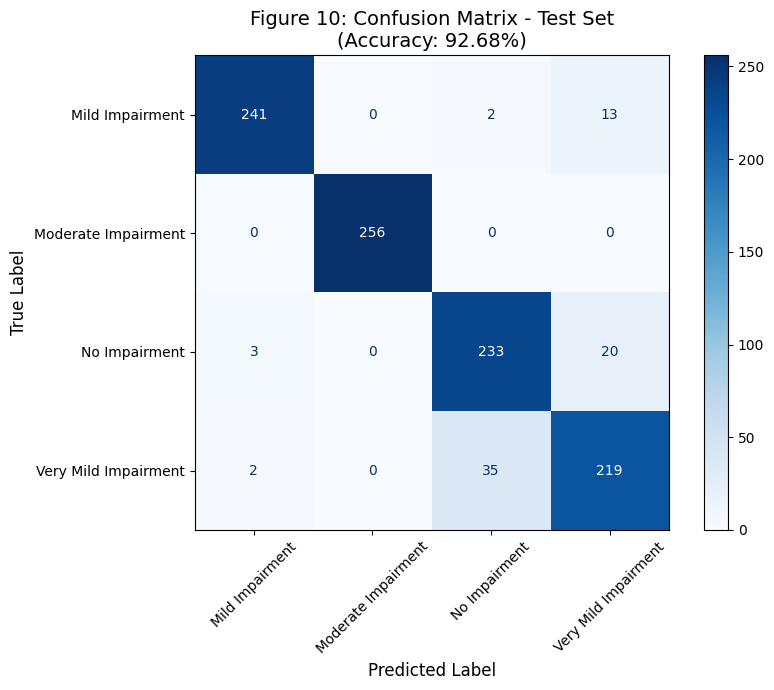


    Generating Normalized Confusion Matrix Plot (Test Data)...
      Saved Normalized Test Confusion Matrix to: /content/figure_extra_test_norm_confusion_matrix.png


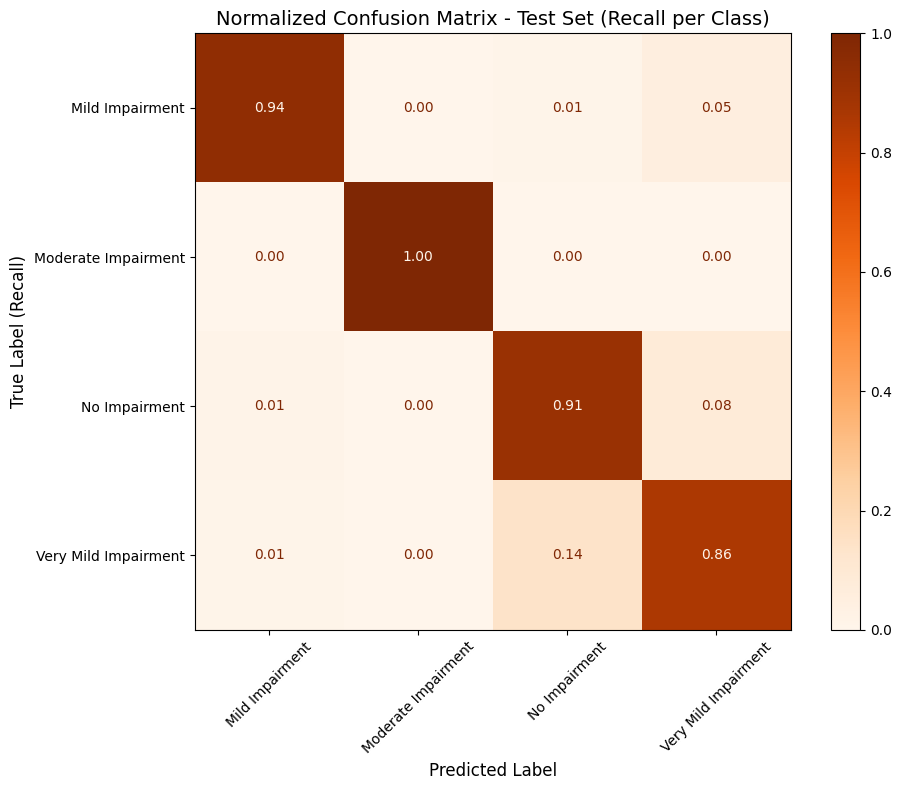


    Generating Figure 11: ROC Curves (Test Data)...
      Saved Test ROC Curves to: /content/figure_11_test_roc_curves.png


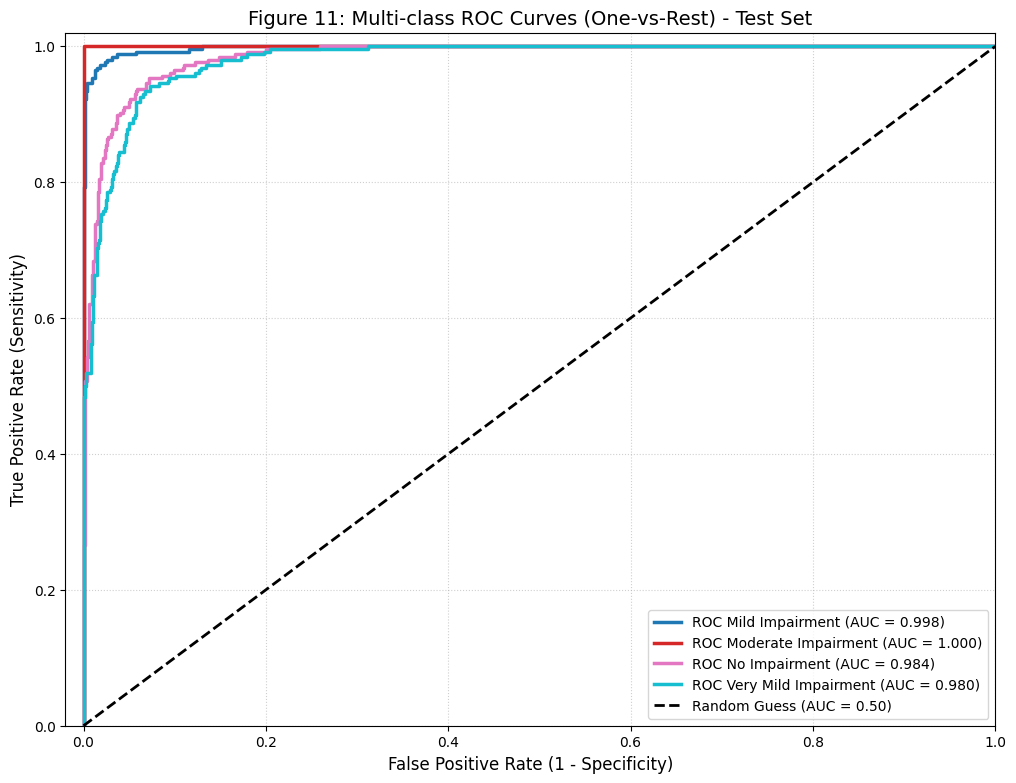


    Generating Figure 12: Precision-Recall Curves (Test Data)...
      Saved Test PR Curves to: /content/figure_12_test_pr_curves.png


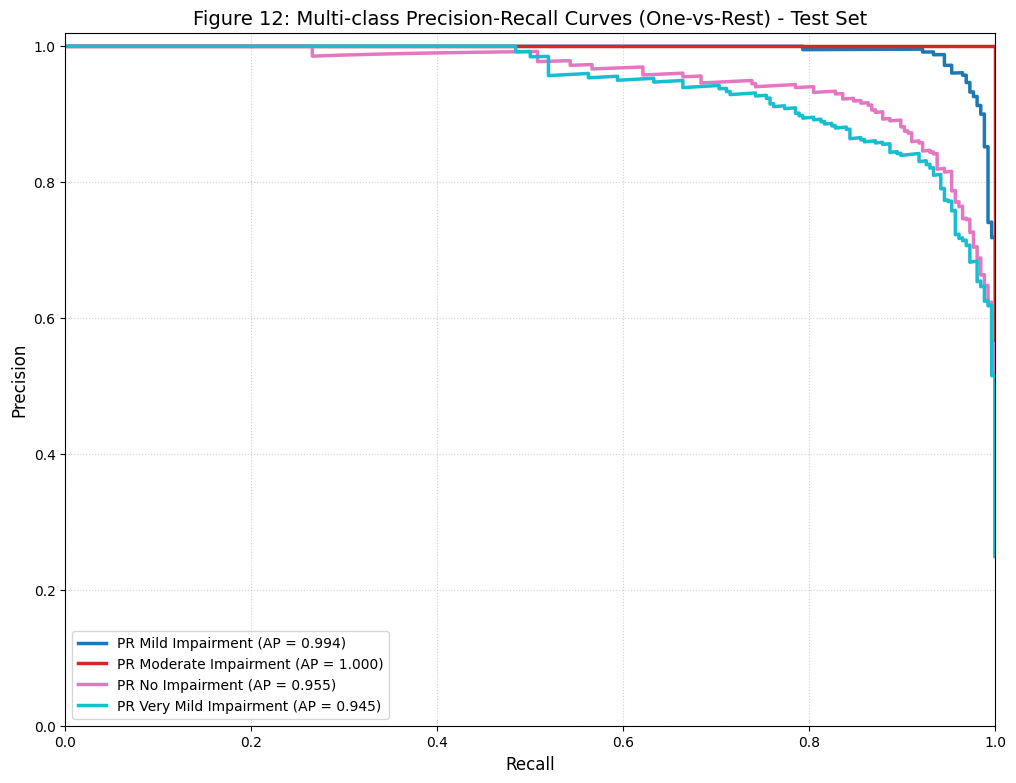


    Generating Figure 13: Per-Class Metrics Bar Chart (Test Data)...
      Error plotting Test metrics bar chart: keyword ha is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid

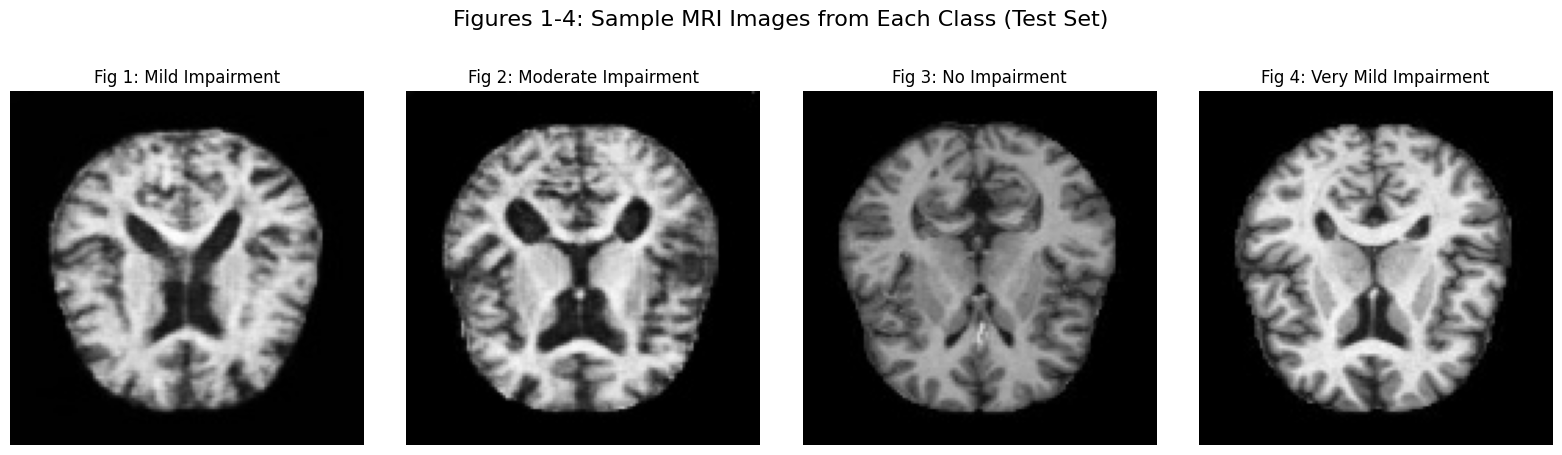

    Sample class image generation took 0.75 seconds.

--- STAGE 4 Complete ---
Model evaluated on the test set.
Performance metrics calculated and printed.
All requested plots (Figures 1-4, 10, Normalized CM, ROC, PR, Per-Class Bar, Sample Predictions) generated and saved to /content/.
Data for Tables 1 (from Stage 2), 3, and 4 has been printed to console.
Remember to manually create Table 2 (Hyperparameters from Stage 1 config & Stage 3 training).

--- ENTIRE PIPELINE COMPLETE ---


--- Corrected Plotting for Figure 13 and Figures 14 & 15 ---

  Checking for necessary variables...
  Necessary variables for plotting found.

  Generating Figure 13: Per-Class Metrics Bar Chart (Test Data)...
    Error plotting Test metrics bar chart: keyword ha is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewi

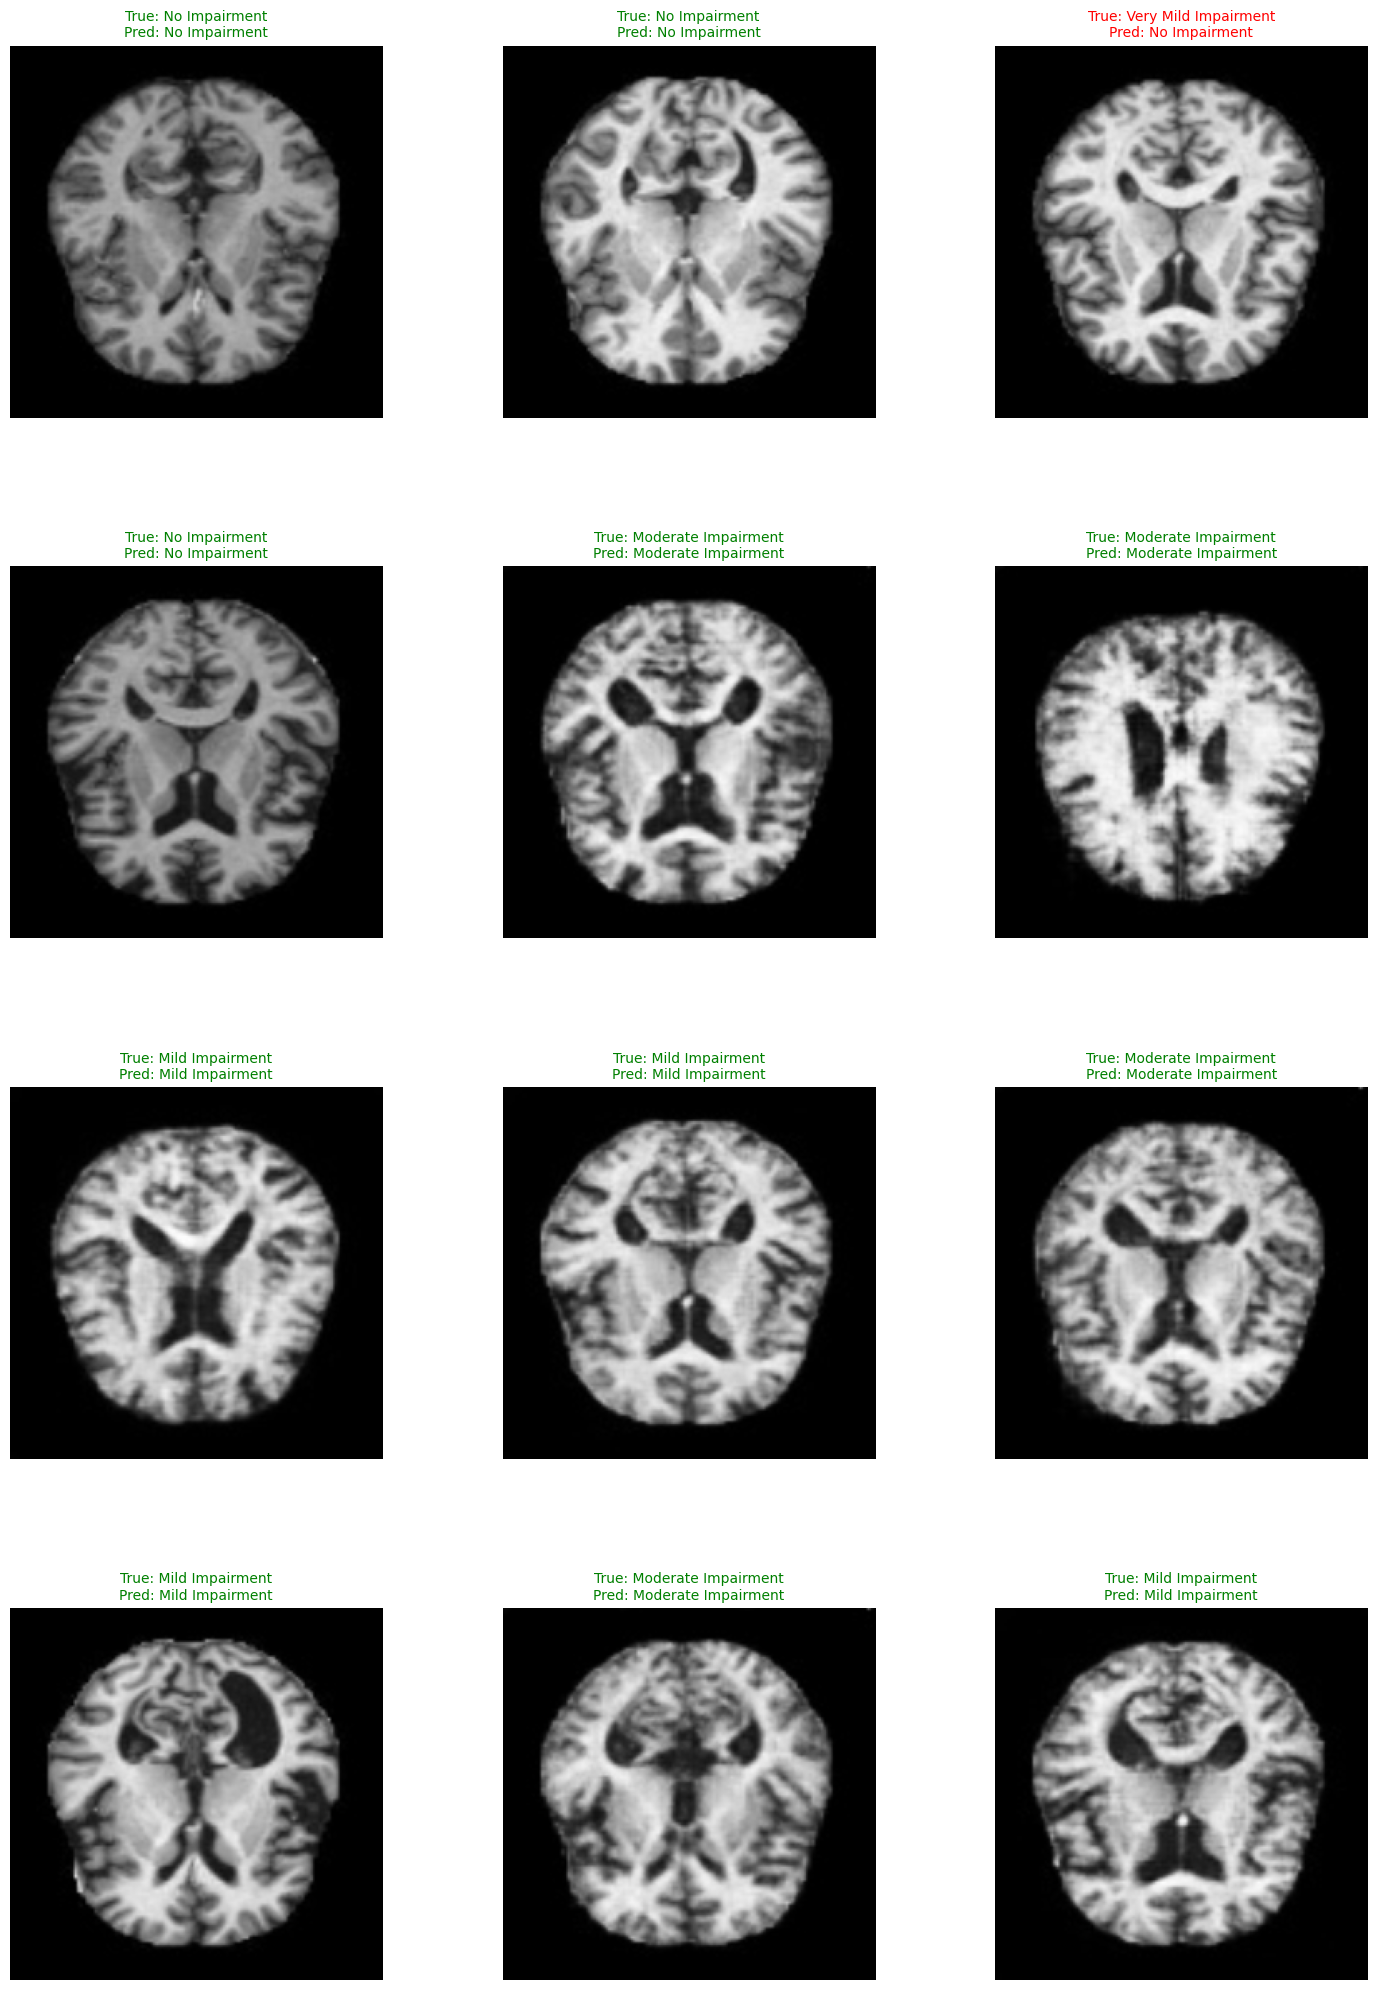


--- Corrected Plotting Complete ---


In [ ]:
# Corrected plotting for Figure 13 and Figures 14 & 15

import matplotlib.pyplot as plt
import seaborn as sns # For Figure 13 if needed, though pandas plot is used
import pandas as pd
import numpy as np
import torch # For denormalize
from PIL import Image # For show_sample_predictions
import os # For path joining

print("--- Corrected Plotting for Figure 13 and Figures 14 & 15 ---")

# === Check for necessary variables from previous successful Stage 4 run ===
print("\n  Checking for necessary variables...")
required_vars_for_plots = [
    'report_dict_s4', 'class_names', 'model', 'test_dl',
    'index_to_label', 'device', 'NUM_CLASSES' # NUM_CLASSES might be needed by denormalize or show_sample_predictions indirectly
]
missing_vars_for_plots = [var for var in required_vars_for_plots if var not in globals()]
if missing_vars_for_plots:
    raise NameError(f"  CRITICAL: Missing variables for plotting: {', '.join(missing_vars_for_plots)}. Ensure Stage 4 data calculation was successful.")
else:
    print("  Necessary variables for plotting found.")

# === Corrected Figure 13: Per-Class Performance Metrics Bar Chart ===
print("\n  Generating Figure 13: Per-Class Metrics Bar Chart (Test Data)...")
try:
    if report_dict_s4 and all(cls_name_bar in report_dict_s4 for cls_name_bar in class_names):
        metrics_to_plot_s4 = {
            'Precision': [report_dict_s4[cls_name_bar]['precision'] for cls_name_bar in class_names],
            'Recall': [report_dict_s4[cls_name_bar]['recall'] for cls_name_bar in class_names],
            'F1-Score': [report_dict_s4[cls_name_bar]['f1-score'] for cls_name_bar in class_names]
        }
        metrics_df_s4 = pd.DataFrame(metrics_to_plot_s4, index=class_names)

        fig_bar_s4, ax_bar_s4 = plt.subplots(figsize=(12, 8))
        metrics_df_s4.plot(kind='bar', ax=ax_bar_s4, colormap='Spectral', width=0.75)
        ax_bar_s4.set_title('Figure 13: Per-Class Performance Metrics on Test Set', fontsize=14, pad=15)
        ax_bar_s4.set_ylabel('Score', fontsize=12, labelpad=10)
        ax_bar_s4.set_xlabel('Alzheimer\'s Stage Class', fontsize=12, labelpad=10)
        ax_bar_s4.tick_params(axis='x', rotation=30, ha='right', fontsize=10)
        ax_bar_s4.tick_params(axis='y', labelsize=10)
        ax_bar_s4.set_ylim([0.0, 1.1])
        ax_bar_s4.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), fancybox=True, shadow=True, ncol=3, fontsize=10)
        ax_bar_s4.grid(axis='y', linestyle='--', alpha=0.7)

        # Add text labels on bars using ax.bar_label
        for container in ax_bar_s4.containers:
            ax_bar_s4.bar_label(container, fmt='%.3f', label_type='edge', fontsize=8, padding=3)

        plt.tight_layout(rect=[0, 0.05, 1, 1]) # Adjust layout to make space for legend
        save_path_bar_test = "/content/figure_13_test_metrics_bar_chart.png"
        plt.savefig(save_path_bar_test, dpi=150, bbox_inches='tight')
        print(f"    Saved Test Per-Class Metrics Bar Chart to: {save_path_bar_test}")
        plt.show()
    else:
        print("    Report dictionary for test set (report_dict_s4) missing required class keys or not populated. Cannot generate metrics bar chart.")
except Exception as e:
    print(f"    Error plotting Test metrics bar chart: {e}")
finally:
    if 'fig_bar_s4' in locals():
        plt.close(fig_bar_s4)

# === Corrected Figures 14 & 15: Sample Prediction Grids ===
print("\n  Generating Figures 14 & 15: Sample Prediction Grids (Test Data)...")

# --- Redefine helper functions to ensure correct version is used ---
print("    Redefining `denormalize` and `show_sample_predictions` functions...")

def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Reverses the normalization transformation for display."""
    # Ensure tensor is on CPU for numpy conversion
    tensor = tensor.cpu()
    # Ensure mean and std are tensors and on the same device as tensor (though tensor is now CPU)
    mean_val = torch.tensor(mean, device=tensor.device).view(3, 1, 1)
    std_val = torch.tensor(std, device=tensor.device).view(3, 1, 1)
    tensor_clone = tensor.clone() # Avoid modifying original tensor
    tensor_clone.mul_(std_val).add_(mean_val) # Reverse normalization: multiply by std, add mean
    tensor_clone = torch.clamp(tensor_clone, 0, 1) # Clamp values to [0, 1] range
    return tensor_clone

def show_sample_predictions(current_model, current_dataloader, current_index_to_label, current_device, num_images=9, filename_prefix="sample_preds"):
    """Displays sample images from a dataloader with true/predicted labels and saves the plot."""
    current_model.eval() # Ensure model is in evaluation mode
    images_so_far = 0
    # Calculate rows needed based on num_images and 3 columns
    rows = int(np.ceil(num_images / 3))
    if rows == 0: # Handle case where num_images is 0
        print("    No images requested for sample predictions (num_images is 0).")
        return

    fig_sp_show, axes_sp_show = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    # Flatten axes array for easy iteration if there's more than one row
    if rows > 1:
        axes_sp_show = axes_sp_show.flatten()
    elif num_images > 0 : # if rows == 1 but num_images > 0, axes_sp_show is 1D
        axes_sp_show = np.array(axes_sp_show).flatten()


    dataloader_iter = iter(current_dataloader)
    print(f"    Attempting to show {num_images} sample predictions...")

    with torch.no_grad(): # No gradients needed for inference
        while images_so_far < num_images:
            try:
                inputs_sp, labels_sp = next(dataloader_iter)
            except StopIteration:
                print("    Reached end of DataLoader while generating sample predictions.")
                break # Exit loop if dataloader is exhausted

            if inputs_sp.numel() == 0: # Skip empty batches
                continue

            inputs_sp = inputs_sp.to(current_device)
            labels_sp = labels_sp.to(current_device)
            outputs_sp = current_model(inputs_sp)
            _, preds_sp = torch.max(outputs_sp, 1) # Get predicted class indices

            for j_sp in range(inputs_sp.size()[0]):
                if images_so_far < num_images:
                    ax_sp = axes_sp_show[images_so_far] # Get the current subplot
                    ax_sp.axis('off')

                    is_correct_sp = (preds_sp[j_sp] == labels_sp[j_sp]).item()
                    true_lbl_sp = current_index_to_label.get(labels_sp[j_sp].item(), "Unknown")
                    pred_lbl_sp = current_index_to_label.get(preds_sp[j_sp].item(), "Unknown")

                    title_color_sp = 'green' if is_correct_sp else 'red'
                    ax_sp.set_title(f'True: {true_lbl_sp}\nPred: {pred_lbl_sp}', color=title_color_sp, fontsize=10)

                    # Denormalize and prepare image for display
                    # Use .data to get the underlying tensor if inputs_sp is a Variable, though it usually isn't in eval
                    img_disp_sp = denormalize(inputs_sp[j_sp]).numpy().transpose((1, 2, 0)) # Pass single image
                    ax_sp.imshow(img_disp_sp)
                    images_so_far += 1
                else:
                    break # Break from inner loop if enough images shown
            if images_so_far >= num_images:
                break # Break from outer loop if enough images shown

    # Turn off axes for any remaining empty subplots
    for k_ax in range(images_so_far, rows * 3):
        if k_ax < len(axes_sp_show): # Check if index is valid
            axes_sp_show[k_ax].axis('off')


    if images_so_far > 0:
        fig_sp_show.tight_layout()
        fig_sp_show.subplots_adjust(hspace=0.4) # Add vertical space between rows of images
        save_path_sp = f"/content/{filename_prefix}_{images_so_far}.png"
        plt.savefig(save_path_sp, dpi=150)
        print(f"      Saved sample predictions plot to: {save_path_sp}")
        plt.show()
    else:
        print("      No images were plotted for sample predictions.")

    # Ensure figure is closed
    if 'fig_sp_show' in locals():
        plt.close(fig_sp_show)
print("    Helper functions for sample predictions redefined.")

try:
    # Call the redefined function with the correct parameters
    show_sample_predictions(
        current_model=model,            # model from Stage 3
        current_dataloader=test_dl,     # test_dl from Stage 2
        current_index_to_label=index_to_label, # index_to_label from Stage 1
        current_device=device,          # device from Stage 3
        num_images=12,                  # Specify number of images
        filename_prefix="figure_14_15_test_sample_predictions" # Specify filename
    )
except Exception as e:
    print(f"    Error generating sample prediction plots: {e}")

print("\n--- Corrected Plotting Complete ---")

--- Corrected Plotting for Figure 13: Per-Class Metrics Bar Chart ---

  Checking for necessary variables for Figure 13...
  Necessary variables for Figure 13 (report_dict_s4, class_names) found.

  Generating Figure 13: Per-Class Metrics Bar Chart (Test Data)...
    Saved Test Per-Class Metrics Bar Chart to: /content/figure_13_test_metrics_bar_chart.png


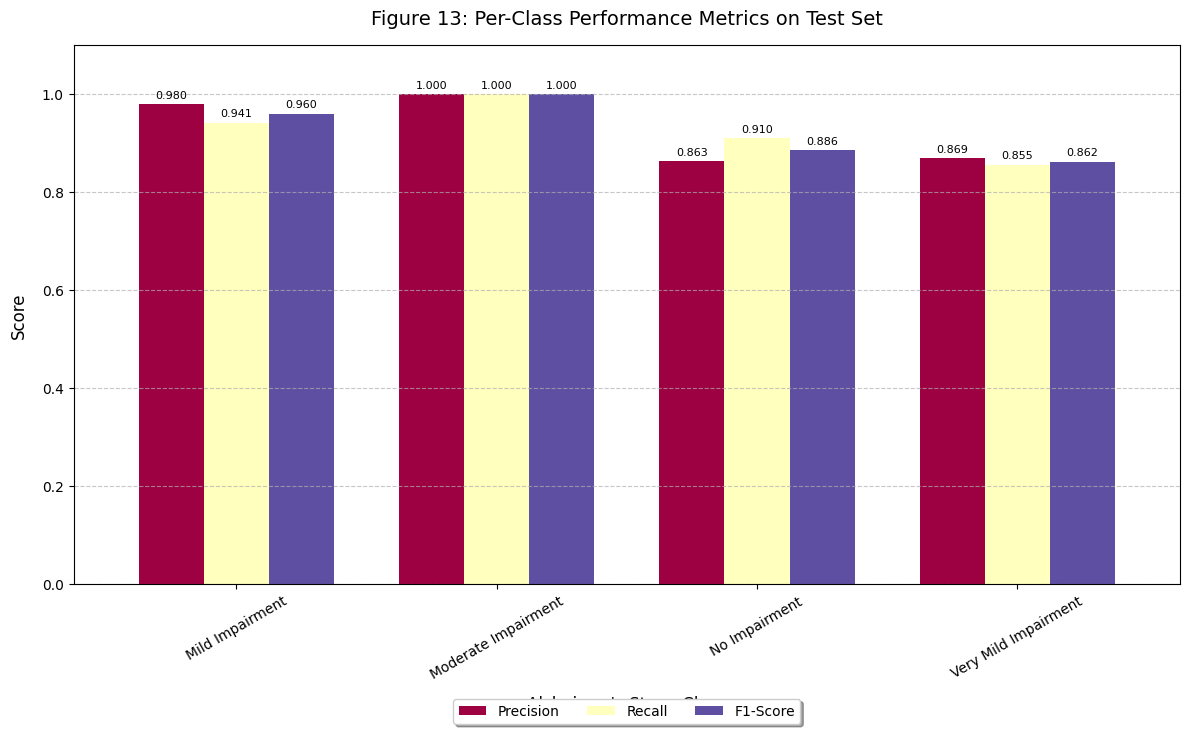


--- Corrected Plotting for Figure 13 Complete ---


In [ ]:
# Corrected plotting for Figure 13 ONLY

import matplotlib.pyplot as plt
import seaborn as sns # Not strictly used for this plot if pandas.plot is used, but good to have
import pandas as pd
import numpy as np # For np.ceil if it were used, not directly here
import os # For path joining

print("--- Corrected Plotting for Figure 13: Per-Class Metrics Bar Chart ---")

# === Check for necessary variables from previous successful Stage 4 run ===
print("\n  Checking for necessary variables for Figure 13...")
required_vars_for_fig13 = ['report_dict_s4', 'class_names']
missing_vars_for_fig13 = [var for var in required_vars_for_fig13 if var not in globals()]

if missing_vars_for_fig13:
    # If these are missing, we might need to re-calculate them from all_labels_test and all_preds_test
    # For now, assume they exist from the previous successful run of Stage 4 evaluation.
    print(f"  WARNING: Missing variables for Figure 13 plotting: {', '.join(missing_vars_for_fig13)}.")
    print("  Attempting to proceed. If 'report_dict_s4' or 'class_names' is missing, this will fail.")
    if 'report_dict_s4' not in globals():
        print("    'report_dict_s4' is definitely missing. You might need to re-run the metric calculation part of Stage 4.")
        # Example re-calculation (ensure all_labels_test, all_preds_test, class_names exist)
        # from sklearn.metrics import classification_report
        # if 'all_labels_test' in globals() and 'all_preds_test' in globals() and 'class_names' in globals():
        #     print("    Attempting to recalculate report_dict_s4...")
        #     report_dict_s4 = classification_report(all_labels_test, all_preds_test, target_names=class_names, output_dict=True, zero_division=0)
        #     print("    report_dict_s4 recalculated.")
        # else:
        #     raise NameError("Cannot recalculate report_dict_s4, critical base variables missing.")
else:
    print("  Necessary variables for Figure 13 (report_dict_s4, class_names) found.")

# === Corrected Figure 13: Per-Class Performance Metrics Bar Chart ===
print("\n  Generating Figure 13: Per-Class Metrics Bar Chart (Test Data)...")
try:
    # Ensure report_dict_s4 is populated and has the required class keys
    if 'report_dict_s4' in globals() and report_dict_s4 and isinstance(report_dict_s4, dict) and \
       'class_names' in globals() and all(cls_name_bar in report_dict_s4 for cls_name_bar in class_names):

        metrics_to_plot_s4 = {
            'Precision': [report_dict_s4[cls_name_bar]['precision'] for cls_name_bar in class_names],
            'Recall': [report_dict_s4[cls_name_bar]['recall'] for cls_name_bar in class_names],
            'F1-Score': [report_dict_s4[cls_name_bar]['f1-score'] for cls_name_bar in class_names]
        }
        metrics_df_s4 = pd.DataFrame(metrics_to_plot_s4, index=class_names)

        fig_bar_s4, ax_bar_s4 = plt.subplots(figsize=(12, 8)) # Create new figure and axes
        metrics_df_s4.plot(kind='bar', ax=ax_bar_s4, colormap='Spectral', width=0.75)
        ax_bar_s4.set_title('Figure 13: Per-Class Performance Metrics on Test Set', fontsize=14, pad=15)
        ax_bar_s4.set_ylabel('Score', fontsize=12, labelpad=10)
        ax_bar_s4.set_xlabel('Alzheimer\'s Stage Class', fontsize=12, labelpad=10)
        # Corrected tick_params: removed 'ha' as it's not a valid keyword here when rotation is used.
        ax_bar_s4.tick_params(axis='x', rotation=30, labelsize=10) # Rotation implies alignment
        ax_bar_s4.tick_params(axis='y', labelsize=10)
        ax_bar_s4.set_ylim([0.0, 1.1]) # Extend y-axis slightly for labels
        ax_bar_s4.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), fancybox=True, shadow=True, ncol=3, fontsize=10)
        ax_bar_s4.grid(axis='y', linestyle='--', alpha=0.7)

        # Add text labels on bars using ax.bar_label (more robust)
        for container in ax_bar_s4.containers:
            ax_bar_s4.bar_label(container, fmt='%.3f', label_type='edge', fontsize=8, padding=3)

        plt.tight_layout(rect=[0, 0.05, 1, 1]) # Adjust layout to make space for legend if legend is below
        save_path_bar_test = "/content/figure_13_test_metrics_bar_chart.png"
        plt.savefig(save_path_bar_test, dpi=150, bbox_inches='tight')
        print(f"    Saved Test Per-Class Metrics Bar Chart to: {save_path_bar_test}")
        plt.show()
    else:
        print("    ERROR: 'report_dict_s4' (classification report dictionary) or 'class_names' not found or not correctly populated.")
        print("    Please ensure the evaluation part of Stage 4 that calculates these metrics ran successfully.")
        if 'report_dict_s4' in globals():
            print(f"    Current report_dict_s4 type: {type(report_dict_s4)}")
            if isinstance(report_dict_s4, dict):
                 print(f"    Keys in report_dict_s4: {list(report_dict_s4.keys())}")
        if 'class_names' in globals():
            print(f"    Current class_names: {class_names}")

except Exception as e:
    print(f"    An error occurred plotting Test metrics bar chart (Figure 13): {e}")
finally:
    if 'fig_bar_s4' in locals(): # Ensure figure object exists before trying to close
        plt.close(fig_bar_s4)

print("\n--- Corrected Plotting for Figure 13 Complete ---")

In [ ]:
# Code to print current hyperparameter variable values for Table 2

print("--- Attempting to Retrieve Hyperparameter Values from Current Session ---")

# Variables typically defined in Stage 1 or early Stage 3
hyperparams_to_print = {
    "EPOCHS": "Number of Epochs Trained",
    "LEARNING_RATE": "Initial Learning Rate",
    "OPTIMIZER_TYPE": "Optimizer Type (e.g., 'Adam', 'SGD')",
    "STEP_SIZE": "LR Scheduler Step Size",
    "GAMMA": "LR Scheduler Gamma",
    "BATCH_SIZE": "Batch Size",
    "IMG_SIZE": "Image Input Size",
    "RANDOM_STATE": "Data Split Random State",
    "device": "Compute Device Used" # From Stage 3 model setup
}

retrieved_values = {}

for var_name, description in hyperparams_to_print.items():
    if var_name in globals():
        retrieved_values[description] = globals()[var_name]
        print(f"  Found: {description} = {globals()[var_name]}")
    else:
        retrieved_values[description] = "NOT FOUND in current session (Manually recall)"
        print(f"  NOT FOUND: {description} (Manually recall or check definition script)")

# Specific PyTorch objects
print("\n  PyTorch Object Details:")
if 'criterion' in globals():
    retrieved_values["Loss Function"] = type(criterion).__name__
    print(f"  Loss Function Type: {type(criterion).__name__}")
else:
    retrieved_values["Loss Function"] = "NOT FOUND (Manually recall: CrossEntropyLoss)"
    print("  Loss Function (criterion) NOT FOUND (Manually recall: CrossEntropyLoss)")

if 'optimizer' in globals():
    retrieved_values["Optimizer Used"] = type(optimizer).__name__
    # This gets the LR of the first parameter group, which is usually the main one
    # Note: this is the *current* LR if scheduler has run.
    # The LEARNING_RATE variable holds the initial setting.
    current_lr_from_optimizer = optimizer.param_groups[0]['lr']
    retrieved_values["Current LR (from optimizer)"] = current_lr_from_optimizer
    print(f"  Optimizer Type: {type(optimizer).__name__}")
    print(f"  Current LR in Optimizer (group 0): {current_lr_from_optimizer}")
else:
    retrieved_values["Optimizer Used"] = "NOT FOUND (Manually recall)"
    print("  Optimizer object NOT FOUND (Manually recall)")

if 'scheduler' in globals():
    retrieved_values["LR Scheduler Type"] = type(scheduler).__name__
    scheduler_state = scheduler.state_dict()
    retrieved_values["LR Scheduler State (step_size, gamma, etc.)"] = scheduler_state
    print(f"  LR Scheduler Type: {type(scheduler).__name__}")
    print(f"  LR Scheduler State: {scheduler_state}") # Contains step_size, gamma, last_epoch etc.
else:
    retrieved_values["LR Scheduler Type"] = "NOT FOUND (Manually recall: StepLR)"
    print("  Scheduler object NOT FOUND (Manually recall: StepLR)")

# Manually added "choice" hyperparameters
retrieved_values["Base Model"] = "ResNet50"
retrieved_values["Pre-trained Weights"] = "ImageNet (IMAGENET1K_V2)"
retrieved_values["Data Split (Tr/Val/Te)"] = "80% / 10% / 10%"

print("\n\n--- Summary for Table 2 (Combine with manual recall if needed) ---")
# Constructing a DataFrame for easier viewing and potential CSV export
table2_data = []
# Order for the table
table_order = [
    "Base Model", "Pre-trained Weights", "Loss Function", "Optimizer Used",
    "Initial Learning Rate", "Current LR (from optimizer)", "LR Scheduler Type",
    "LR Scheduler State (step_size, gamma, etc.)", "LR Scheduler Step Size", "LR Scheduler Gamma",
    "Batch Size", "Number of Epochs Trained", "Image Input Size",
    "Data Split (Tr/Val/Te)", "Data Split Random State", "Compute Device Used"
]

for key in table_order:
    value = retrieved_values.get(key, "Manually recall or check definition")
    # Specifically handle scheduler state for better readability if needed
    if key == "LR Scheduler State (step_size, gamma, etc.)" and isinstance(value, dict):
        # Extract relevant parts if you want, or just keep the dict string
        value_str = f"step_size={value.get('step_size', 'N/A')}, gamma={value.get('gamma', 'N/A')}, last_epoch={value.get('last_epoch', 'N/A')}"
        table2_data.append({"Parameter": key, "Value": value_str})
    elif key == "LR Scheduler Step Size" and "LR Scheduler State (step_size, gamma, etc.)" in retrieved_values and isinstance(retrieved_values["LR Scheduler State (step_size, gamma, etc.)"], dict):
        table2_data.append({"Parameter": key, "Value": retrieved_values["LR Scheduler State (step_size, gamma, etc.)"].get('step_size', 'N/A')})
    elif key == "LR Scheduler Gamma" and "LR Scheduler State (step_size, gamma, etc.)" in retrieved_values and isinstance(retrieved_values["LR Scheduler State (step_size, gamma, etc.)"], dict):
        table2_data.append({"Parameter": key, "Value": retrieved_values["LR Scheduler State (step_size, gamma, etc.)"].get('gamma', 'N/A')})
    else:
        table2_data.append({"Parameter": key, "Value": value})


df_table2 = pd.DataFrame(table2_data)
print(df_table2.to_markdown(index=False, numalign="left", stralign="left"))

print("\n--- End of Hyperparameter Retrieval ---")
print("Please review the 'Value' column. If it says 'NOT FOUND' or needs more detail (like for scheduler state),")
print("you'll need to manually recall those values from the code where they were defined (likely Stage 1 or start of Stage 3).")
print("The 'Initial Learning Rate' is from the LEARNING_RATE variable. 'Current LR' is from the optimizer object.")

--- Attempting to Retrieve Hyperparameter Values from Current Session ---
  Found: Number of Epochs Trained = 10
  Found: Initial Learning Rate = 0.001
  Found: Optimizer Type (e.g., 'Adam', 'SGD') = Adam
  Found: LR Scheduler Step Size = 7
  Found: LR Scheduler Gamma = 0.1
  Found: Batch Size = 16
  Found: Image Input Size = 224
  Found: Data Split Random State = 42
  Found: Compute Device Used = cuda

  PyTorch Object Details:
  Loss Function Type: CrossEntropyLoss
  Optimizer Type: Adam
  Current LR in Optimizer (group 0): 0.0001
  LR Scheduler Type: StepLR
  LR Scheduler State: {'step_size': 7, 'gamma': 0.1, 'base_lrs': [0.001], 'last_epoch': 10, 'verbose': False, '_step_count': 11, '_get_lr_called_within_step': False, '_last_lr': [0.0001]}


--- Summary for Table 2 (Combine with manual recall if needed) ---
| Parameter                                   | Value                                 |
|:--------------------------------------------|:--------------------------------------|


# New Section

In [ ]:
import torchvision.models as models
import torch

# Initialize the ResNet50 model architecture
model = models.resnet50(pretrained=False)   # pretrained=False because we are loading your custom-trained weights
model.fc = torch.nn.Linear(in_features=2048, out_features=4)

# Transfer to device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# Path where your model is saved (update if you have a different path)
model_path = '/content/alzheimer_resnet50_best_trained_acc_0.9219.pth'

# Load the saved model weights
model.load_state_dict(torch.load(model_path, map_location=device))

# Set the model to evaluation mode (important for inference)
model.eval()
print("✅ Model loaded and ready for inference!")


FileNotFoundError: [Errno 2] No such file or directory: '/content/alzheimer_resnet50_best_trained_acc_0.9219.pth'